# Predicting Location via Indoor Positioning System 
## Analysis and Modeling in Python 
This script and subsequent notebooks are the Python conversion of the Indoor Location case study from the book, 'Data Science in R' by Nolan and Lang. http://rdatasciencecases.org/code.html <BR>
* Team: Jonathan Tan, Lance Dacy, Reannan Mcdaniel, Shawn Jung 
* Last Update: 5/14/2020 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.spatial import distance
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
%matplotlib inline 

In [2]:
# We will load offline data, and filter out non-related MACs
offline = pd.read_csv('./data/offline_processed.csv')
legit_ap = offline['mac'].value_counts().index[0:7]
offline = offline[offline['mac'].isin(legit_ap)]

# Let's load online data 
online = pd.read_csv('./data/online_processed.csv')
online = online[online['mac'].isin(legit_ap)]

online_pivot = pd.read_csv('./data/online_pivot.csv')
online_pivot[['pos_x', 'pos_y']] = online_pivot['pos_xy'].str.split('-',n=2, expand=True).astype(float)

### Train data selection(sampling)
The test data(ONLINE) was measured in specific angles. So we will try to use test data(OFFLINE) measured with similar angles, by choosing 45 degree left, 45 degree right and the actual degree. So 135(45*3) degrees of train data will be selected per each test data prediction

In [3]:
# augmenting angles by adding 45 on both wings
def angle_selecter(angle):
    angle_m = angle
    angle_l = angle-45
    angle_r = angle+45
    
    angle = np.array([angle_l, angle_m, angle_r])
    angle = np.where(angle >= 360, angle-360, angle)
    angle = np.where(angle < 0, angle+360, angle)
    
    return angle

In [4]:
# Let's define a train data selector, by giving three different angle ranges 
def train_select(train_full_df, angle=0):
    ''' this function gets the OFFLINE data frame, and filter out by specified angles(orientations) '''
    angles = angle_selecter(angle)

    train_pivot = train_full_df[train_full_df['orientation'].isin(angles)].reset_index(drop=True)
    train_pivot['pos_xy'] = train_pivot[['pos_x', 'pos_y']].astype(str).agg('-'.join, axis=1)
    train_pivot = pd.pivot_table(train_pivot, values='signal', index='pos_xy', columns='mac', aggfunc=np.median).reset_index()
    train_pivot[['pos_x', 'pos_y']] = train_pivot['pos_xy'].str.split('-',n=2, expand=True).astype(float)
    train_pivot = train_pivot.reset_index(drop=True)
    train_pivot = train_pivot[['pos_xy', '00:0f:a3:39:e1:c0', '00:0f:a3:39:dd:cd', '00:14:bf:b1:97:8a',
       '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:8d', '00:14:bf:b1:97:90',
       '00:14:bf:b1:97:81', 'pos_x', 'pos_y']]
    return train_pivot


In [5]:
# We prepare pivotted data for every angles, and save them as a whole. We found that it took long time when selecting training data angle on the fly during location matching. 
for i, angle in enumerate([0, 45, 90, 135, 180, 225, 270, 315]):
    if i==0:
        offline_pivot = train_select(offline,0) 
        offline_pivot['orientation'] = angle
    else:
        temp_df = train_select(offline,angle) 
        temp_df['orientation'] = angle
        offline_pivot = offline_pivot.append(temp_df)

offline_pivot = offline_pivot.reset_index(drop=True)


In [6]:
# Save the interim file as CSV for future use. The process above can take long time. 
offline_pivot.to_csv('./data/offline_pivot.csv', index=False)

In [9]:
# The function returns the index of top k nearest neighbors and the distance 
def find_NN(test_array, train_df_raw, angle, sig_col=[1,2,3,4,5,6], k=1, distance_type=distance.euclidean):
    ''' the 'index' of nearest points are returned. '''
    
    train_df = train_df_raw[train_df_raw['orientation'] == angle].reset_index(drop=True)

    dist = {} # to return calculated distance with index

    for i in range(train_df.shape[0]):
        #d = np.sqrt(np.sum(np.square((np.array(test_array) - np.array(train_df)[i]))))
        d = distance_type(test_array[sig_col], np.array(train_df)[i][sig_col])
        dist[i] = d
        
    # sort the data by distance, and choose the lowest top k elements    
    dist = {key: v for key, v in sorted(dist.items(), key=lambda item: item[1])[:k]}
    
    coord = train_df.iloc[list(dist.keys())][['pos_x', 'pos_y']].values

    return dist, coord

# For sanity check 
#find_NN(online_all.iloc[0], offline_all, k=4)

In [10]:
p, s = find_NN(online_pivot.iloc[59], offline_pivot, angle=180, k=3)
print(p,s)

{2: 4.439553473414099, 6: 6.320615920641341, 74: 6.4234856272118055} [[ 0. 10.]
 [ 0.  2.]
 [ 2.  2.]]


In [ ]:
online_pivot.iloc[59]

In [15]:
error_calc(59, online_pivot, p, s)

(10.744825999247933, 0.5775086194142695, 5.3423346186622025)

In [35]:
# The function calculates weighted or simple averaged predicted location, and compare to the actual location. And then return the gap as error 
def error_calc(original_index, test_df, predict_dict, predict_coord, weighted_mean=True, distance_type=distance.cityblock):
    original_xy = test_df.iloc[original_index][['pos_x', 'pos_y']]
    # define place holders 
    dist = []
    pred_x, pred_y = predict_coord[:,0], predict_coord[:,1]

    for predict_index, dist_value in predict_dict.items():
        
        #pred_y.append(predict_coord[:,1])
        dist.append(1/dist_value+0.00001) #weighted sum by 1/distance

    dist_weight= np.array(dist)/np.sum(dist)

    # in case we use weighted mean, 
    if weighted_mean:
        avg_pred_x = np.average(pred_x, weights=dist_weight)
        avg_pred_y = np.average(pred_y, weights=dist_weight)
        
    else:
        avg_pred_x = np.average(pred_x)
        avg_pred_y = np.average(pred_y)

    error = distance_type(original_xy, (avg_pred_x, avg_pred_y))
    
    #return error
    return error, avg_pred_x, avg_pred_y
    
# for sanity check
# error_calc(0, online_all, p, offline_all)

In [36]:
# This function calculated the mean errors per combination of datasets, k(number of neighbors), distance type and averaging type
def location_scoring(test_df, train_df, k=1, weighted_mean=True, sig_col=[1,2,3,4,5,6], cv_mode=False):
    errors = []
    pred_xs, pred_ys = [], []

    for i in range(test_df.shape[0]):
        if cv_mode == True:
            angle = 180
        else:
            angle = test_df.iloc[i]['orientation']

        predicted_dicts, pred_coords = find_NN(test_df.iloc[i], train_df, angle, sig_col, k)
        error, pred_x, pred_y = error_calc(i, test_df, predicted_dicts, pred_coords, weighted_mean)
        errors.append(error)
        pred_xs.append(pred_x)
        pred_ys.append(pred_y)
    
    return np.mean(errors), pred_xs, pred_ys


In [18]:
#location_scoring(online_pivot, offline_pivot, k=1, weighted_mean=True, sig_col=[1,2,3,4,5,6], cv_mode=False)

### Training and Testing 

1. We will first choose the best working angles range, and distance method(weighted mean vs. simple mean) <BR>
2. Once the parameters are set, we will run Cross Validation of the model best-fits our train data by observing consistency. <BR>
3. Then, we will compare the scores from test data set. This time, we will compare with three different MAC address choice - CD(6 MAC), C0(6 MAC) and ALL 7 

Spot-check (which angles, which mean distance method, which k) <BR>
We will make grid-search of hyper parameters on OFFLINE data, by spliting it into 70% train and 30% test. For k, we will apply from 1 to 10, weighted/simple means, and 8 different angle variations will be applied to find the best parameter

In [26]:
k_space = [1,2,3,4,5,6,7,8,9,10]
errors = []
weighted_means = [True, False]
angles = [0, 45, 90, 135, 180, 225, 270, 315]
#kf = KFold(n_splits=5, random_state=42)

cv_df = offline_pivot.copy().drop(['00:0f:a3:39:e1:c0'], axis=1)
offline_train, offline_test = train_test_split(cv_df, test_size=0.3, random_state=42)

for mean_method in weighted_means:
    for k in k_space:
            #scores = []
            
        error, _, _ = location_scoring(offline_test, offline_train, sig_col=[1,2,3,4,5,6], k=k, weighted_mean=mean_method)
        errors.append(error)
        
        print(f'weighted_mean={mean_method}, k = {k}')
        #print(f'weighted_mean={mean_method}, k = {k} , mean error = {mean_error:.4f}')

weighted_mean=True, k = 1
weighted_mean=True, k = 2
weighted_mean=True, k = 3
weighted_mean=True, k = 4
weighted_mean=True, k = 5
weighted_mean=True, k = 6
weighted_mean=True, k = 7
weighted_mean=True, k = 8
weighted_mean=True, k = 9
weighted_mean=True, k = 10
weighted_mean=False, k = 1
weighted_mean=False, k = 2
weighted_mean=False, k = 3
weighted_mean=False, k = 4
weighted_mean=False, k = 5
weighted_mean=False, k = 6
weighted_mean=False, k = 7
weighted_mean=False, k = 8
weighted_mean=False, k = 9
weighted_mean=False, k = 10


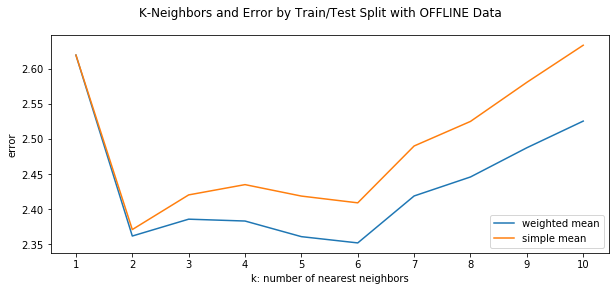

In [31]:
# It appears that we get good 'elbow' value when k=2 with Weighted Mean method

fig, axs = plt.subplots(figsize=(10,4))
    
axs.plot(k_space, errors[0:10], label='weighted mean')
axs.plot(k_space, errors[10:20], label='simple mean')
    
plt.xticks(k_space)

plt.suptitle('K-Neighbors and Error by Train/Test Split with OFFLINE Data')
plt.xlabel('k: number of nearest neighbors')
plt.ylabel('error')
plt.legend()
plt.show()

In [40]:
# Let's confirm if we see consistent results with Cross Validation 

cv_errors = []
kf = KFold(n_splits=10, random_state=42)
kf.get_n_splits(cv_df)

cv_df2 = cv_df[cv_df['orientation'] == 180]

for train_index, test_index in kf.split(cv_df2):
    cv_error, _, _ = location_scoring(cv_df2.iloc[test_index], cv_df2.iloc[train_index], sig_col=[1,2,3,4,5,6], k=2, weighted_mean=True)
    cv_errors.append(cv_error)


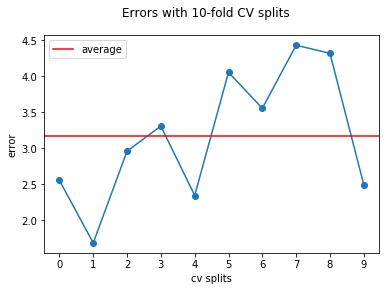

In [65]:
# It seems that the erros lie within 1 standard deviation of the mean error. 
_, ax = plt.subplots()

ax.plot(cv_errors, marker='o') 
_.suptitle('Errors with 10-fold CV splits')
plt.axhline(np.mean(cv_errors), c='r', label='average')
plt.xlabel('cv splits')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.ylabel('error')
plt.legend()
plt.show()

In [69]:

# Let's define 6 MAC addresses, by choosing the one end with 'CD'. 
offline_cd = offline_pivot.drop(['00:0f:a3:39:e1:c0'], axis=1)
online_cd = online_pivot.drop(['00:0f:a3:39:e1:c0'], axis=1)

# These are data sets when choosing 'C0'
offline_c0 = offline_pivot.drop(['00:0f:a3:39:dd:cd'], axis=1)
online_c0 = online_pivot.drop(['00:0f:a3:39:dd:cd'], axis=1)

# Datasets when we take all 7 MAC addresses
offline_all = offline_pivot
online_all = online_pivot


Case 1-3 and 1-4 <BR>
Let's compare which one gives better performance. From our analysis, C0 MAC group showed slightly lower error, but overall error values with test dataset(ONLINE data) is higher than the training dataset

In [70]:
scores_c0, c0_x, c0_y = location_scoring(online_c0, offline_c0, sig_col=[1,2,3,4,5,6], k=2, weighted_mean=True)
scores_cd, cd_x, cd_y = location_scoring(online_cd, offline_cd, sig_col=[1,2,3,4,5,6], k=2, weighted_mean=True)
scores_all, all_x, all_y = location_scoring(online_all, offline_all, sig_col=[1,2,3,4,5,6,7], k=2, weighted_mean=True)

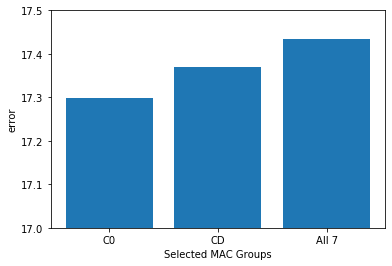

In [74]:
plt.bar(['C0', 'CD', 'All 7'], [scores_c0, scores_cd, scores_all])
plt.ylim([17, 17.5])
plt.xlabel('Selected MAC Groups')
plt.ylabel('error')
plt.show()

In [75]:
print(scores_c0, scores_cd, scores_all)

17.298336002952723 17.37061630492043 17.433842487081815


### Case 1-4 
This model appears to be not good for actual use, since the error value is around 17 which doesn't give value for location prediction. When we compare the coordinates of original locations and predicted locations, we see the prediction is not well spanning to x-axis. <BR>
Suggestions <BR>
* Considering the rectangular floor layout, we might apply different weights to horizontal x-axis coordinates when calculating distances 
* The distribution of signals can be different when we measured the offline data, and online data. We can think of a normalizer or regularizer function before applying 'find neighbor' function

In [76]:
# Let's see why this happens
comparison = online_c0[['pos_x', 'pos_y']].copy()
comparison['pred_x'] = c0_x
comparison['pred_y'] = c0_y


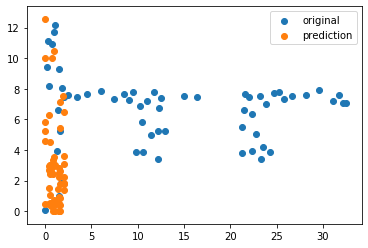

In [77]:
plt.scatter('pos_x', 'pos_y', data=comparison, label='original')
plt.scatter('pred_x', 'pred_y', data=comparison, label='prediction')
plt.legend()
plt.show()